In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

### **Fetch preprocessed train data**

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = "drive/MyDrive/team_folder/data/custom_data/"
all_data = pd.read_csv(data_dir + "categorical_train_set.csv", sep = ',')

print(all_data.shape)

data = all_data.sample(frac=1, random_state=42) # Randomly select

(20216100, 14)


In [ ]:
print(data.columns)

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'],
      dtype='object')


### **Feature Engineering**

In [ ]:
def filter_by_meter_type(df_original, meter_type):
  assert type(meter_type) == int
  df = df_original.copy()
  df = df[df['meter'] == meter_type]
  df = df.drop(columns=['meter'])
  return df

def add_hour_column(df_original):
  df = df_original.copy()
  df['timestamp'] = pd.to_datetime(df['timestamp'])
  df['hour'] = df.timestamp.dt.hour
  return df

def convert_timestamp_to_numerical(df_original):
  df = df_original.copy()
  df.timestamp = pd.to_datetime(df.timestamp)
  time_start = np.datetime64('2016-01-01 00:00:00')
  df['timestamp'] = (df['timestamp'] - time_start) / np.timedelta64(3600, 's') 
  return df

In [ ]:
data = add_hour_column(data)
data = convert_timestamp_to_numerical(data)
data = filter_by_meter_type(data, meter_type=0)

data.columns

Index(['building_id', 'timestamp', 'meter_reading', 'site_id', 'primary_use',
       'square_feet', 'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
       'wind_speed', 'hour'],
      dtype='object')

In [ ]:
desired_columns = ['timestamp', 'square_feet',
                   'primary_use',
                   'air_temperature', 'cloud_coverage', 'dew_temperature',
                   'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
                   'wind_speed', 'hour', 'meter_reading']
data = data[desired_columns]
print(data.columns)

data.primary_use = pd.Categorical(data.primary_use)
data['primary_use_code'] = data.primary_use.cat.codes

Index(['timestamp', 'square_feet', 'primary_use', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'hour',
       'meter_reading'],
      dtype='object')


In [ ]:
# ========== Features and Target ========== 
target_column = ['meter_reading']
feature_columns = ['timestamp', 'square_feet',
                   'primary_use_code',
                   'air_temperature', 'cloud_coverage', 'dew_temperature',
                   'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction',
                   'wind_speed', 'hour']

# ========== X & y ========== 
data = data.dropna()
X_pandas = data[feature_columns]
y_pandas = data[target_column]
X = np.array(X_pandas.values, dtype=np.float32)
y = np.array(y_pandas.values, dtype=np.float32)

### **Train & Test**

In [ ]:
# ========== Test/Validation Split ========== 
# test_sizes = [0.1, 0.2, 0.25, 0.3, 0.33, 0.4]
# def find_best_test_size():
#   for test_size in test_sizes:
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### **Evaluation**

In [ ]:
max_depth_list = [5, 10, 20, 30, 40, 50, 60, 70, 73, 80]
max_leaf_nodes_list = [5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 
1000000, 2000000, 3000000, 4000000, 5000000, 5900000, 6000000, 
7000000, 8000000, 8125347, 9000000]

def hyperparameter_tuning(hyperparameter='max_depth'):
  # num_nodes_list = []
  # num_leaves_list = []
  # depth_list = []
  # train_accs = []
  # test_accs = []
  # train_errors = []
  # test_errors = []

  num_nodes_list, num_leaves_list, depth_list, train_accs, test_accs, train_errors, test_errors = [], [], [], [], [], [], []
  hyperparameters = []

  if (hyperparameter == 'max_depth'):
    hyperparameters = max_depth_list
  elif (hyperparameter == 'max_leaf_nodes'):
    hyperparameters = max_leaf_nodes_list

  for param in hyperparameters:
    model = DecisionTreeRegressor(max_depth=param, random_state=42)
    if (hyperparameter == 'max_leaf_nodes'):
      model = DecisionTreeRegressor(max_leaf_nodes=param, random_state=42)
    reg = model.fit(X_train, y_train)

    num_nodes = model.tree_.node_count
    num_leaves = model.get_n_leaves()
    depth = model.tree_.max_depth

    num_nodes_list.append(num_nodes)
    num_leaves_list.append(num_leaves)
    depth_list.append(depth)

    # ========== Regression Score ========== -> Not applicable on our task
    train_acc = reg.score(X_train, y_train)
    test_acc = reg.score(X_test, y_test)

    train_accs.append(train_acc)
    test_accs.append(test_acc)

    # ========== RMSLE ==========
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_rmsle = mean_squared_log_error(y_train, y_train_pred, squared=False)
    test_rmsle = mean_squared_log_error(y_test, y_test_pred, squared=False)

    train_errors.append(train_rmsle)
    test_errors.append(test_rmsle)

  return num_nodes_list, num_leaves_list, depth_list, train_accs, test_accs, train_errors, test_errors

# ========== RESULT ==========
num_nodes_list, num_leaves_list, depth_list, train_accs, test_accs, train_errors, test_errors = hyperparameter_tuning('max_leaf_nodes')
print('Number of nodes:', num_nodes_list)
print('Number of leaves:', num_leaves_list)
print('Depth:', depth_list)
print('Train_acc:', train_accs)
print('Test_acc:', test_accs)
print('Train RMSLE:', train_errors)
print('Test RMSLE:', test_errors)



Number of nodes: [9, 19, 99, 199, 999, 1999, 9999, 19999, 99999, 199999, 999999, 1999999, 3999999, 5999999, 7999999, 9999999, 11799999, 11999999, 13999999, 15999999, 16250693, 17999999]
Number of leaves: [5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 2000000, 3000000, 4000000, 5000000, 5900000, 6000000, 7000000, 8000000, 8125347, 9000000]
Depth: [3, 5, 11, 13, 20, 25, 51, 51, 53, 53, 59, 61, 62, 65, 67, 69, 72, 72, 72, 73, 73, 73]
Train_acc: [0.4065108708749817, 0.5197372309805621, 0.7901060044114891, 0.8380567593220786, 0.9195446946319497, 0.938739143148516, 0.9762722868144271, 0.9843724844134445, 0.9944571343954123, 0.9965442775051417, 0.9988818557745677, 0.9992132746874216, 0.999342924865365, 0.9993693133472216, 0.9993768514993836, 0.9993792293144489, 0.9993799442889065, 0.9993799866050708, 0.9993802189390653, 0.9993802640838872, 0.9993802654949875, 0.9993802685639478]
Test_acc: [0.4108886394220783, 0.5247624496428569, 0.7980458457348465, 0.8453854431185066

### **Overfitting**

14


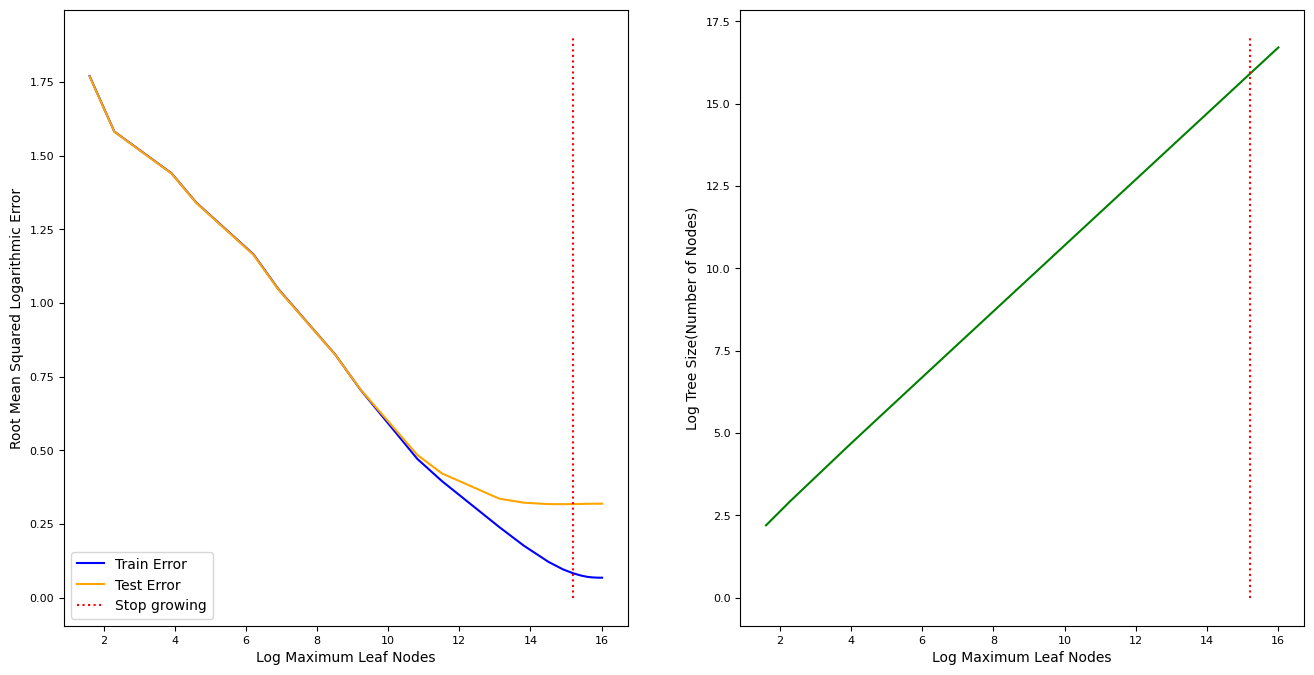

In [ ]:
def find_overfitting(hyperparameter = 'max_depth'):
  hyperparameters = []
  if (hyperparameter == 'max_depth'):
    hyperparameters = max_depth_list
  else:
    hyperparameters = max_leaf_nodes_list

  prev_train_error = 0
  prev_test_error = 1
  for i, param in enumerate(max_leaf_nodes_list):
    train_error = train_errors[i]
    test_error = test_errors[i]
    if (train_error < prev_train_error and test_error > prev_test_error):
      return i
    prev_train_error = train_error
    prev_test_error = test_error
  return False

index_overfitting = find_overfitting('max_leaf_nodes')

# ========== Plot Overfitting by hyperparameter tuning ==========
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

axs[0].plot(np.log(np.array(max_leaf_nodes_list)), np.array(train_errors), c='blue', label='Train Error')
axs[0].plot(np.log(np.array(max_leaf_nodes_list)), np.array(test_errors), c='orange', label='Test Error')
axs[0].plot(np.array([np.log(max_leaf_nodes_list[index_overfitting])] * 20), np.array(range(0, 20)) * 0.1, c='red', label='Stop growing', linestyle='dotted')

axs[1].plot(np.log(np.array(max_leaf_nodes_list)), np.log(np.array(num_nodes_list)), c='green', label='Tree Size (Numer of nodes)')
axs[1].plot(np.array([np.log(max_leaf_nodes_list[index_overfitting])] * 18), np.array(range(0, 18)), c='red', label='Stop growing', linestyle='dotted')

axs[0].legend(loc='best')
axs[0].tick_params(axis='both', which='major', labelsize=8)
axs[0].set_xlabel('Log Maximum Leaf Nodes')
axs[0].set_ylabel('Root Mean Squared Logarithmic Error')

axs[1].tick_params(axis='both', which='major', labelsize=8)
axs[1].set_xlabel('Log Maximum Leaf Nodes')
axs[1].set_ylabel('Log Tree Size(Number of Nodes)')

plt.show()

### **Final Model & Test Error(Root Mean Squared Log Error)**

In [ ]:
max_leaf_nodes = max_leaf_nodes_list[index_overfitting]
final_model = DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=42)

y_test_pred = final_model.predict(X_test)
test_rmsle = mean_squared_log_error(y_test, y_test_pred, squared=False)